# Загрузка библиотек

In [1]:
import numpy as np
import os
import cv2
import glob
import random
import pickle
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from tqdm import tqdm
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Rescaling
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.preprocessing import image
from keras.utils import np_utils

seed = 21

# Параметры

In [2]:
TRAINDIR = "D:\\Jupyter\\Image_Data\\Train"

TESTDIR = "D:\\Jupyter\\Image_Data\\Test"

CATEGORIES = ["buildings", "forest", "mountain", "sea"]

CLASS_NUM = 4

IMG_SIZE = (150, 150)

BATCH_SIZE = 32

# Загрузка данных

In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINDIR,
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

validate = tf.keras.preprocessing.image_dataset_from_directory(
    TESTDIR,
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 9248 files belonging to 4 classes.
Found 1946 files belonging to 4 classes.


# Загруженные изображения

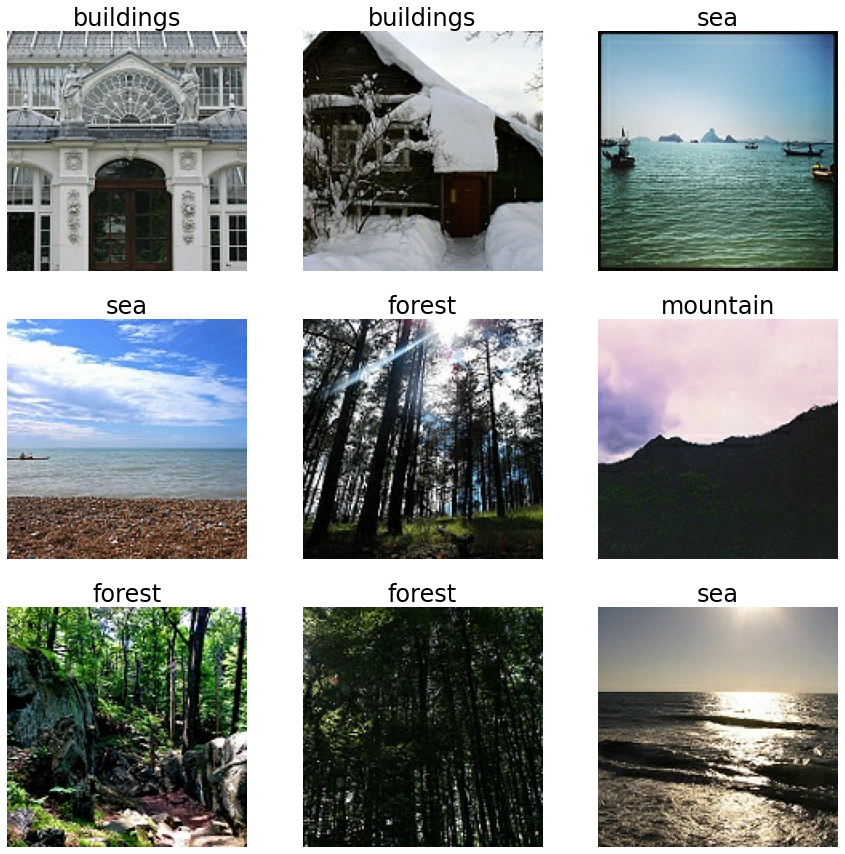

In [4]:
plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CATEGORIES[int(labels[i])])
        plt.axis("off")

# Буферизация

In [5]:
train = train.prefetch(buffer_size=32)
validate = validate.prefetch(buffer_size=32)

# Модификация данных

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# Пример модифицированных данных

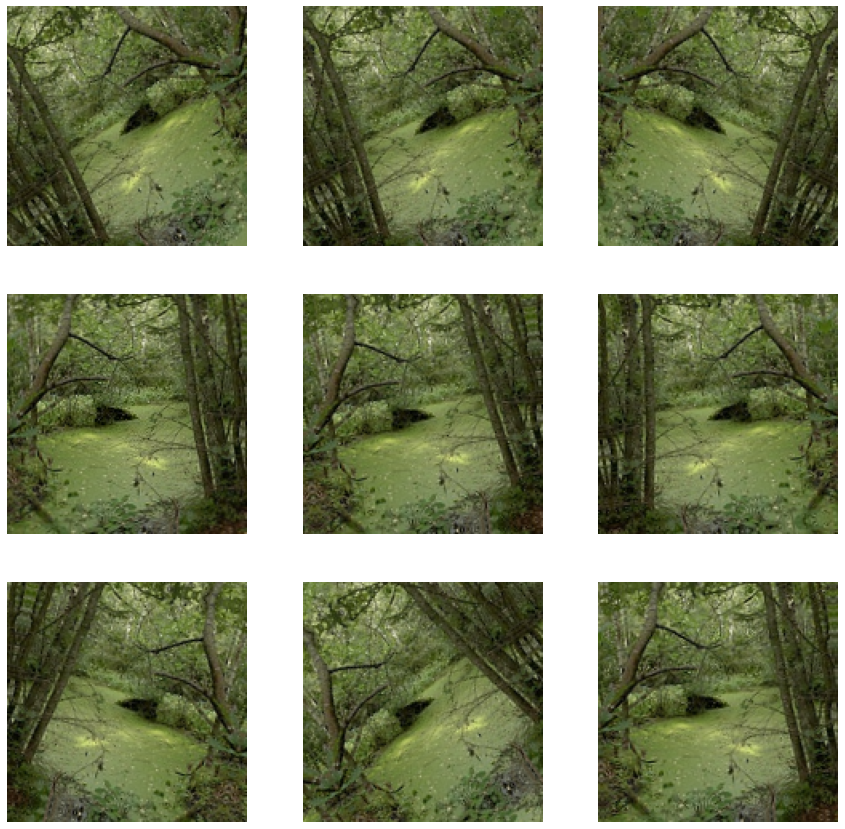

In [7]:
plt.figure(figsize=(15, 15))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Создание модели

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=IMG_SIZE + (3,), num_classes = CLASS_NUM)
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Обучение модели

In [9]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("Model_Saves\\save_at_{epoch}.h5"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train, epochs=epochs, callbacks=callbacks, validation_data = validate,
)

Epoch 1/10
289/289 [==============================] - 425s 1s/step - loss: 0.6862 - accuracy: 0.7306 - val_loss: 2.5012 - val_accuracy: 0.2621


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/10
289/289 [==============================] - 446s 2s/step - loss: 0.4459 - accuracy: 0.8377 - val_loss: 0.4763 - val_accuracy: 0.8135
Epoch 3/10
289/289 [==============================] - 449s 2s/step - loss: 0.3596 - accuracy: 0.8700 - val_loss: 0.5054 - val_accuracy: 0.8052
Epoch 4/10
289/289 [==============================] - 449s 2s/step - loss: 0.3246 - accuracy: 0.8828 - val_loss: 0.4022 - val_accuracy: 0.8690
Epoch 5/10
289/289 [==============================] - 450s 2s/step - loss: 0.2796 - accuracy: 0.9002 - val_loss: 0.3103 - val_accuracy: 0.8869
Epoch 6/10
289/289 [==============================] - 446s 2s/step - loss: 0.2669 - accuracy: 0.9098 - val_loss: 0.2908 - val_accuracy: 0.8993
Epoch 7/10
289/289 [==============================] - 448s 2s/step - loss: 0.2443 - accuracy: 0.9135 - val_loss: 0.4643 - val_accuracy: 0.8386
Epoch 8/10
289/289 [==============================] - 431s 1s/step - loss: 0.2409 - accuracy: 0.9161 - val_loss: 0.4072 - val_accuracy: 0.8551

# Загрузка модели

In [10]:
model = keras.models.load_model("Model_Saves\\save_at_10.h5")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   896         ['rescaling[0][0]']          

# Разделение видео на фреймы

In [11]:
FRAME_PER_SEC = 10

video_path = "D:\\Jupyter\\Videos\\Test0.mp4"
path = "D:\\Jupyter\\Video_Frames"

videos = glob.glob(path + "\\*")
for video in videos:
    os.remove(video)

count = 0
vidcap = cv2.VideoCapture(video_path)
success,image = vidcap.read()
success = True
while success:
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000)) 
    success, image = vidcap.read()
    print ('Read a new frame: ', success)
    if(success):
        cv2.imwrite(path + "\\frame%d.jpg" % count, image)
        count = count + 1 * FRAME_PER_SEC

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  False


# Создание набора данных из фреймов

In [12]:
video_frames = []

for img in os.listdir(path): 
    print(img)
    img_array = cv2.imread(os.path.join(path, img))
    img_array = cv2.resize(img_array, IMG_SIZE)
    video_frames.append(img_array)
    
video_frames = np.array(video_frames)

frame0.jpg
frame10.jpg
frame100.jpg
frame110.jpg
frame120.jpg
frame130.jpg
frame140.jpg
frame150.jpg
frame160.jpg
frame170.jpg
frame180.jpg
frame190.jpg
frame20.jpg
frame200.jpg
frame210.jpg
frame220.jpg
frame230.jpg
frame240.jpg
frame250.jpg
frame260.jpg
frame270.jpg
frame280.jpg
frame290.jpg
frame30.jpg
frame300.jpg
frame310.jpg
frame320.jpg
frame330.jpg
frame340.jpg
frame350.jpg
frame360.jpg
frame370.jpg
frame380.jpg
frame40.jpg
frame50.jpg
frame60.jpg
frame70.jpg
frame80.jpg
frame90.jpg


# Фреймы после обработки

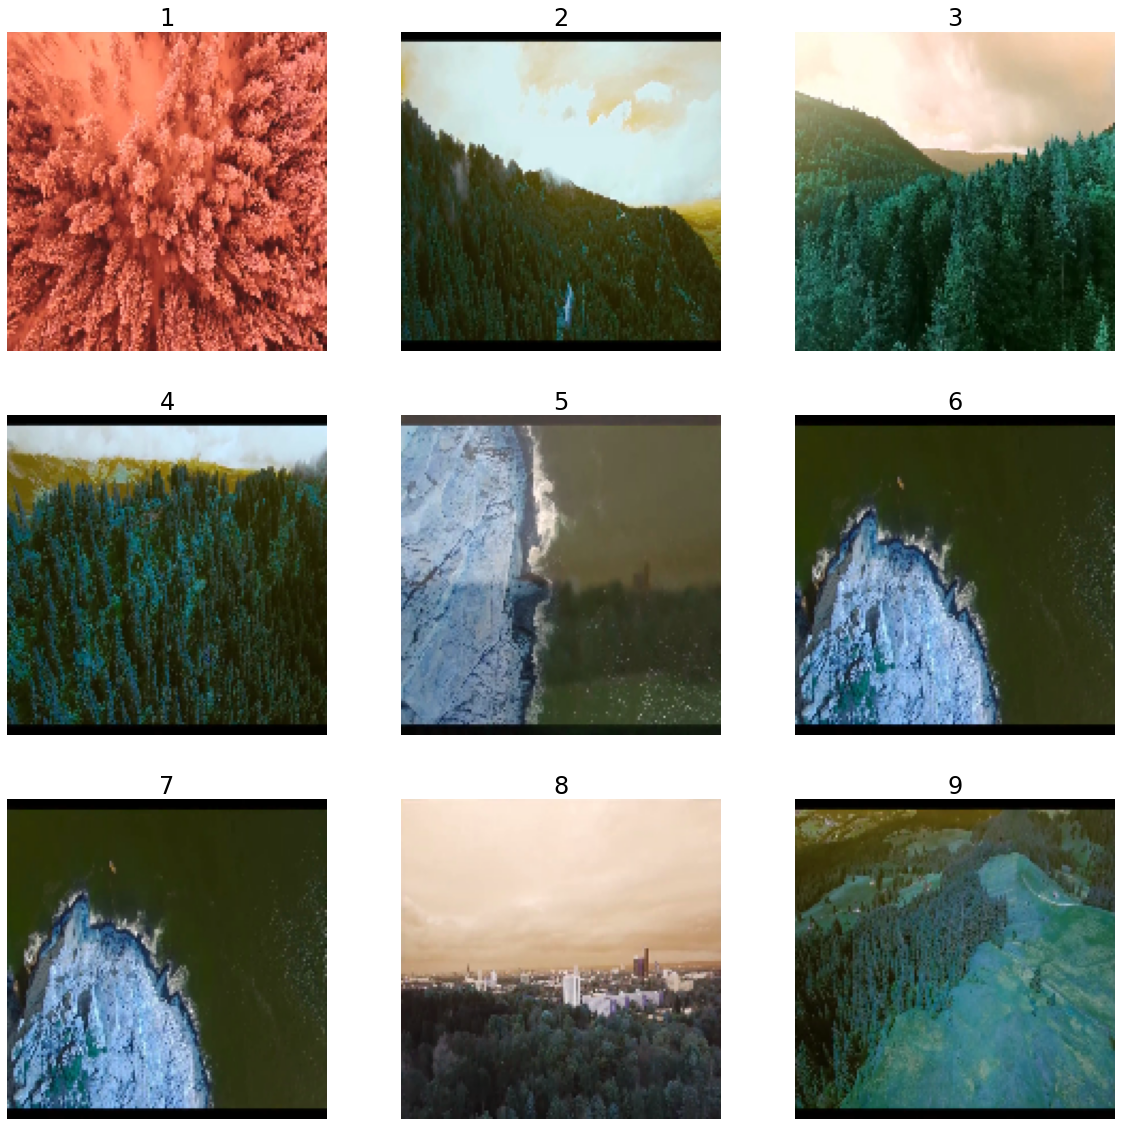

In [13]:
fig = plt.figure(figsize=(20, 20))

for i in range(9):
    img_array = random.choice(video_frames)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img_array.astype("uint8"))
    plt.title(i+1)
    plt.axis("off")

# Результаты для первых 12 фреймов

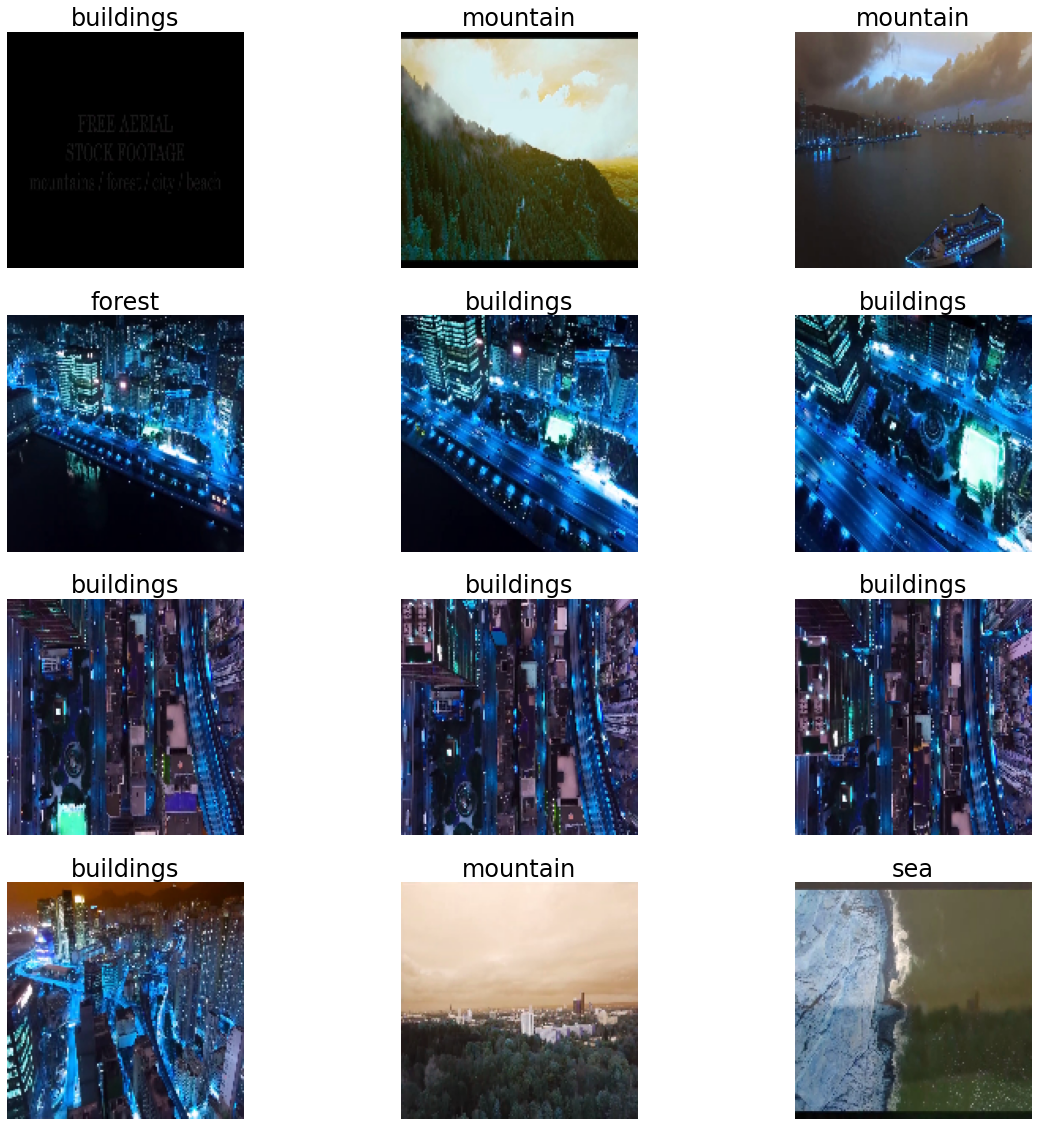

In [14]:
predictions = model.predict(video_frames)

fig = plt.figure(figsize=(20, 20))

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(video_frames[i].astype("uint8"))
    plt.title(CATEGORIES[np.argmax(predictions[i])])
    plt.axis("off")

# Результаты для случайных фреймов

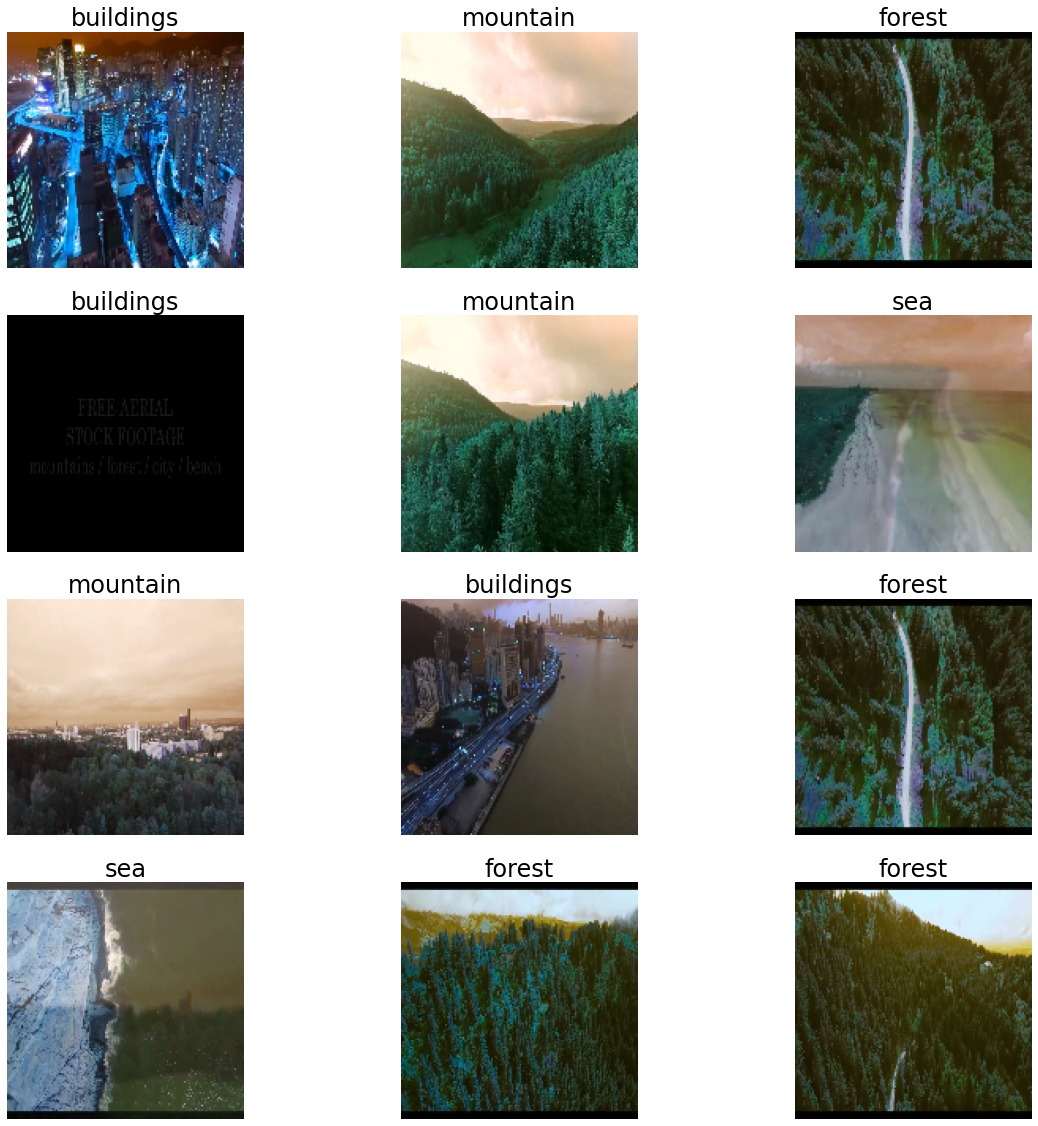

In [19]:
fig = plt.figure(figsize=(20, 20))

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    random_img = random.choice(video_frames)
    prediction = model.predict(np.array([random_img]))
    plt.imshow(random_img.astype("uint8"))
    plt.title(CATEGORIES[np.argmax(prediction[0])])
    plt.axis("off")

In [17]:
    prediction = model.predict(np.array([video_frames[3]]))
    print(CATEGORIES[np.argmax(prediction[0])])

forest
